In [9]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 20

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of the training data for validation
)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    'Dataset_Train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load the validation data
validation_generator = train_datagen.flow_from_directory(
    'Dataset_Val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load VGG16 Pretrained Model and Freeze Layers
base_model = VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

# Build the Model
model = Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Regularization via Dropout
    layers.BatchNormalization(),  # Batch Normalization
    layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer for 4 classes
])


# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

class_weights = {0: 1.0, 1: 0.8, 2: 0.9}
model.fit(train_generator, validation_data=validation_generator, epochs=20, class_weight=class_weights)


# Model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)

# Save the model
model.save('improved_model.h5')


Found 117 images belonging to 3 classes.
Found 5 images belonging to 3 classes.
Epoch 1/20
4/4 [==============================] - 13s 3s/step - loss: 1.7291 - accuracy: 0.4017 - val_loss: 1.6698 - val_accuracy: 0.4000
Epoch 2/20
4/4 [==============================] - 11s 3s/step - loss: 1.6761 - accuracy: 0.4274 - val_loss: 1.8069 - val_accuracy: 0.4000
Epoch 3/20
4/4 [==============================] - 12s 3s/step - loss: 1.5512 - accuracy: 0.4359 - val_loss: 1.9388 - val_accuracy: 0.4000
Epoch 4/20
4/4 [==============================] - 12s 3s/step - loss: 1.4830 - accuracy: 0.5128 - val_loss: 1.7535 - val_accuracy: 0.4000
Epoch 5/20
4/4 [==============================] - 12s 3s/step - loss: 1.5011 - accuracy: 0.4615 - val_loss: 1.7461 - val_accuracy: 0.2000
Epoch 6/20
4/4 [==============================] - 12s 3s/step - loss: 1.4245 - accuracy: 0.5385 - val_loss: 1.4631 - val_accuracy: 0.2000
Epoch 7/20
4/4 [==============================] - 12s 3s/step - loss: 1.5481 - accuracy: 0.3

C:\Users\Kavana K\anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Check class indices
print(train_generator.class_indices)


{'IR Patch': 0, 'Negative Patch': 1, 'Positive Patch': 2}


Found 145 images belonging to 3 classes.
5/5 [==============================] - 13s 3s/step
[[24  0 11]
 [12 18 19]
 [ 2  1 58]]
                precision    recall  f1-score   support

      IR Patch       0.63      0.69      0.66        35
Negative Patch       0.95      0.37      0.53        49
Positive Patch       0.66      0.95      0.78        61

      accuracy                           0.69       145
     macro avg       0.75      0.67      0.66       145
  weighted avg       0.75      0.69      0.67       145



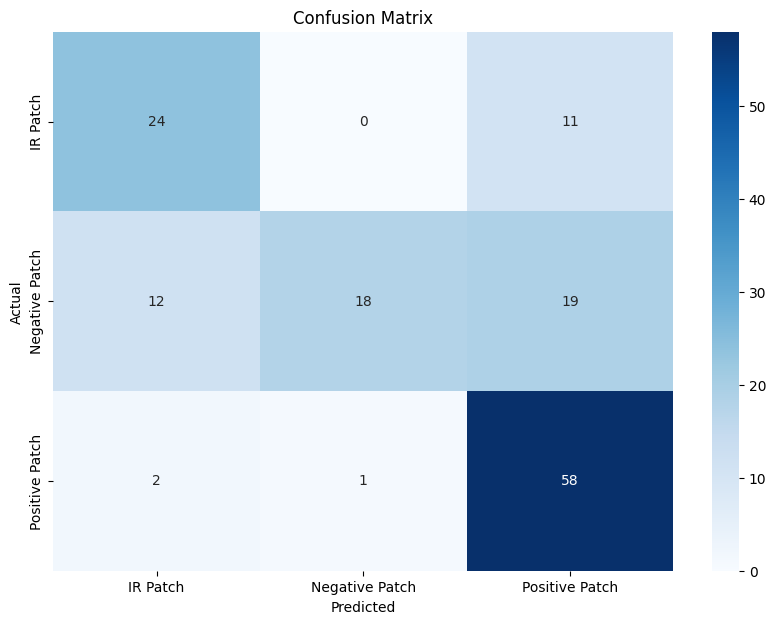

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming you have test data and true labels
test_data_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)
class_mapping = {
    0: 'IR Patch',
    1: 'Negative Patch',
    2: 'Positive Patch'
}

# Get predictions
y_pred = model.predict(test_data_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_data_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_mapping.values()))

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
